# 2. Niveles lingüísticos II

## Objetivos

- Los alumnæs comprenderán la importancia de las etiquetas *POS* en tareas de _NLP_
- Implementar un modelo de etiquetado automático
  - Usando modelos discriminativos _HMMs_
  - Usando modelos condicionales _CRFs_
  - Contrastar ambos enfoques para generación automática de secuencias de etiquetas

## Etiquetas _Part Of Speech (POS)_

- Etiquetas que hacen explicita la funcion gramatical de las palabras en una oración
- Determina la función de la palabra dentro la oración (por ello se le llama Partes del Discurso)
- Se le conoce tambien como Análisis morfosintáctico: es el puente entre la estructura de las palabras y la sintaxis
- Permiten el desarrollo de herramientas de NLP más avanzadas

<center><img src="https://byteiota.com/wp-content/uploads/2021/01/POS-Tagging.jpg" height=500 width=500></center>

### Categorias comúnes

- Sustantivos - (NOUN)
- Adjetivos - (ADV)
- Verbos - (VERB)

#### Ejemplo

> El gato negro rie malvadamente

- El - DET
- gato - NOUN
- negro - ADJ
- ríe - VERB

<center><img src="https://i.pinimg.com/originals/0e/f1/30/0ef130b255ea704625b2ad473701dee5.gif"></center>

### Materia prima de otras tareas de NLP

- Named entity recognition (NER)
- Statistical language models
- Text generation
- Sentient analysis

## Etiquetado automático POS (*POS tagging*)

- El etiquetado POS es una tarea del NLP dónde se le asigna de forma automática una etiqueta según su función a cada palabra tomando en cuenta el contexto de la oración.

- En esta tarea se toma en cuenta cierta estructura de la oración.

- En un enfoque probabilístico queremos obtener: $P(\overrightarrow{x},\overrightarrow{y})$


donde:
- $\overrightarrow{x}$ = $<x_1,x_2,...,x_n>$
- $\overrightarrow{y}$ = $<y_1,y_2,...,y_n>$
- $x_i = palabra$ y $y_i = etiqueta\ POS$

### Un primer acercamiento: Hidden Markov Models (HMM)

<center><img src="https://www.davidsbatista.net/assets/images/2017-11-11-HMM.png"></center>

$p(\overrightarrow{x},\overrightarrow{y}) = \displaystyle\prod_{i=1}^{n} p(y_i|y_{i-1}) ⋅ p(x_i|y_i)$

Donde:
- $\overrightarrow{y} = secuencia\ de\ etiquetas\ POS$
- $\overrightarrow{x} = secuencia\ de\ palabras$

### Suposición de Markov

> "The probability of a particular state is dependent only on the previous state"

#### Características

- Clasificador secuencial
    - Dada una secuencia de entrada se predice la secuencia de salida más probable
    - Se apreden los parámetros de secuencias previamente etiquetadas

### Componentes del framework HMM


- Estados (etiquetas): $T = t_1,t_2,...,t_n$
- Observaciones (palabras): $W = w_1,w_2,...,w_n$
- Estados iniciales y finales

#### Probabilidades asociadas a estados

- Matriz $A$ con las probabilidades de ir de un estado a otro
- Matriz $B$ con las probabilidades de que una observasión se genera a partir de un estado
- Probabilidades asociadas a los estados iniciales y finales

### ¿Qué soluciona HMM?

1. Aprender parámetros asociados con una secuencia de observación dada (training step)
    - Dada una lista de palabras y sus etiquetas POS asociadas, el modelo aprende la estructura dada
2. Aplicar un modelo HMM previamente entrenado
    - Dada una nueva oración nunca antes vista, se puede **predecir** la etiqueta POS asociada a cada palabra de dicha oración usando la estructura aprendida

## Implementación

### 0. Instalación de dependencias

In [ ]:
!pip install nltk
!pip install scikit-learn

In [66]:
import nltk

# Descargando el corpus cess_esp: https://www.nltk.org/book/ch02.html#tab-corpora
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to
[nltk_data]     /home/umoqnier/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [67]:
from nltk.corpus import cess_esp
# Cargando oraciones
corpora = cess_esp.tagged_sents()

In [68]:
corpora[0]

[('El', 'da0ms0'),
 ('grupo', 'ncms000'),
 ('estatal', 'aq0cs0'),
 ('Electricité_de_France', 'np00000'),
 ('-Fpa-', 'Fpa'),
 ('EDF', 'np00000'),
 ('-Fpt-', 'Fpt'),
 ('anunció', 'vmis3s0'),
 ('hoy', 'rg'),
 (',', 'Fc'),
 ('jueves', 'W'),
 (',', 'Fc'),
 ('la', 'da0fs0'),
 ('compra', 'ncfs000'),
 ('del', 'spcms'),
 ('51_por_ciento', 'Zp'),
 ('de', 'sps00'),
 ('la', 'da0fs0'),
 ('empresa', 'ncfs000'),
 ('mexicana', 'aq0fs0'),
 ('Electricidad_Águila_de_Altamira', 'np00000'),
 ('-Fpa-', 'Fpa'),
 ('EAA', 'np00000'),
 ('-Fpt-', 'Fpt'),
 (',', 'Fc'),
 ('creada', 'aq0fsp'),
 ('por', 'sps00'),
 ('el', 'da0ms0'),
 ('japonés', 'aq0ms0'),
 ('Mitsubishi_Corporation', 'np00000'),
 ('para', 'sps00'),
 ('poner_en_marcha', 'vmn0000'),
 ('una', 'di0fs0'),
 ('central', 'ncfs000'),
 ('de', 'sps00'),
 ('gas', 'ncms000'),
 ('de', 'sps00'),
 ('495', 'Z'),
 ('megavatios', 'ncmp000'),
 ('.', 'Fp')]

In [69]:
import requests

def get_tags_map():
    tags_raw = requests.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")

def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    result = []
    for sentence in corpora:
        result.append([(word, map_tag(tag)) for word, tag in sentence])
    return result

In [70]:
corpora = parse_tags(corpora)

In [71]:
corpora[0]

[('El', 'DET'),
 ('grupo', 'NOUN'),
 ('estatal', 'ADJ'),
 ('Electricité_de_France', 'NOUN'),
 ('-Fpa-', '.'),
 ('EDF', 'NOUN'),
 ('-Fpt-', '.'),
 ('anunció', 'VERB'),
 ('hoy', 'ADV'),
 (',', '.'),
 ('jueves', 'NOUN'),
 (',', '.'),
 ('la', 'DET'),
 ('compra', 'NOUN'),
 ('del', 'ADP'),
 ('51_por_ciento', 'NUM'),
 ('de', 'ADP'),
 ('la', 'DET'),
 ('empresa', 'NOUN'),
 ('mexicana', 'ADJ'),
 ('Electricidad_Águila_de_Altamira', 'NOUN'),
 ('-Fpa-', '.'),
 ('EAA', 'NOUN'),
 ('-Fpt-', '.'),
 (',', '.'),
 ('creada', 'ADJ'),
 ('por', 'ADP'),
 ('el', 'DET'),
 ('japonés', 'ADJ'),
 ('Mitsubishi_Corporation', 'NOUN'),
 ('para', 'ADP'),
 ('poner_en_marcha', 'VERB'),
 ('una', 'DET'),
 ('central', 'NOUN'),
 ('de', 'ADP'),
 ('gas', 'NOUN'),
 ('de', 'ADP'),
 ('495', 'NUM'),
 ('megavatios', 'NOUN'),
 ('.', '.')]

In [72]:
# ¿Cuantas oraciones tenemos disponibles?
len(corpora)

6030

In [75]:
from sklearn.model_selection import train_test_split
# Separando en dos conjuntos, uno para entrenamiento y otro para pruebas
train_data, test_data = train_test_split(corpora, test_size=0.3, random_state=42)

In [76]:
# Comprobemos la longitud de la data
len(train_data), len(test_data)

(4221, 1809)

In [78]:
len(train_data) + len(test_data) == len(corpora)

True

### 2. Entrenamiento

In [79]:
from nltk.tag import hmm

# Creando el modelo HMM usando nltk
trainer = hmm.HiddenMarkovModelTrainer()

# Hora de entrenar
hmm_model = trainer.train(train_data)

### 3. Resultados

In [80]:
tagged_test_data = hmm_model.tag_sents([[word for word, _ in sent] for sent in test_data])

/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


In [81]:
tagged_test_data[0]

[('El', 'DET'),
 ('técnico', 'NOUN'),
 ('barcelonista', 'ADJ'),
 ('ha', 'VERB'),
 ('asegurado', 'VERB'),
 ('que', 'CONJ'),
 ('la', 'DET'),
 ('visita', 'NOUN'),
 ('de', 'ADP'),
 ('Gaspart', 'ADP'),
 ('ha', 'ADP'),
 ('contribuido', 'ADP'),
 ('a', 'ADP'),
 ('"', 'ADP'),
 ('sumar', 'ADP'),
 ('"', 'ADP'),
 (',', 'ADP'),
 ('y', 'ADP'),
 ('*0*', 'ADP'),
 ('ha', 'ADP'),
 ('argumentado', 'ADP'),
 ('que', 'ADP'),
 ('el', 'ADP'),
 ('encuentro', 'ADP'),
 ('con', 'ADP'),
 ('el', 'ADP'),
 ('presidente', 'ADP'),
 ('significa', 'ADP'),
 ('que', 'ADP'),
 ('en', 'ADP'),
 ('el', 'ADP'),
 ('Barcelona', 'ADP'),
 ('"', 'ADP'),
 ('todos', 'ADP'),
 ('van', 'ADP'),
 ('en', 'ADP'),
 ('la', 'ADP'),
 ('misma', 'ADP'),
 ('dirección', 'ADP'),
 ('"', 'ADP'),
 ('.', 'ADP')]

In [82]:
# Extrayendo tags verdaderas vs tags predichas
y_true = [tag for sent in test_data for _, tag in sent]
y_pred = [tag for sent in tagged_test_data for _, tag in sent]

In [83]:
y_true[:3]

['DET', 'NOUN', 'ADJ']

In [84]:
y_pred[:3]

['DET', 'NOUN', 'ADJ']

In [85]:
from collections import defaultdict

def report_accuracy(y_true: list, y_pred: list) -> defaultdict:

    label_accuracy_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    for gold_tag, predicted_tag in zip(y_true, y_pred):
        label_accuracy_counts[gold_tag]["total"] += 1
        if gold_tag == predicted_tag:
            label_accuracy_counts[gold_tag]["correct"] += 1
    
    # Calculate and display the accuracy for each label
    print("Label\tAccuracy")
    for label, counts in label_accuracy_counts.items():
        accuracy = counts["correct"] / counts["total"] if counts["total"] > 0 else 0.0
        print(f"{label}\t{accuracy * 100:.2f}%")
    return label_accuracy_counts

In [86]:
label_accuracy_counts = report_accuracy(y_true, y_pred)

Label	Accuracy
DET	32.70%
NOUN	26.55%
ADJ	21.27%
VERB	27.80%
CONJ	25.55%
ADP	99.91%
.	21.80%
PRON	27.66%
ADV	33.62%
NUM	14.90%
X	0.00%


In [87]:
nltk.download('punkt')ADP

[nltk_data] Downloading package punkt to /home/umoqnier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [92]:
#unseen_sentence = "La casa es grande y luminosa."
unseen_sentence = "La muchacha vio al dinosaurio con el telescopio"
#unseen_sentence = "El gato rie malvadamente"

# Tokenizando
tokenized_sentence = nltk.word_tokenize(unseen_sentence)

# Haciendo predicciones
predicted_tags = [tag for word, tag in hmm_model.tag(tokenized_sentence)]

print("Palabra \tPOS Tag (predicha)")
for word, tag in zip(tokenized_sentence, predicted_tags):
    print(f"{word}\t{tag}")

Palabra 	POS Tag (predicha)
La	DET
muchacha	ADP
vio	ADP
al	ADP
dinosaurio	ADP
con	ADP
el	ADP
telescopio	ADP


### Comparando con modelos pre-entrenados

- [Model information](https://spacy.io/models/es)

In [ ]:
!python -m spacy download es_core_news_sm

In [93]:
import spacy
# spacy.cli.download("") # Direct from python

nlp = spacy.load("es_core_news_sm")
doc = nlp(unseen_sentence)
print([(w.text, w.pos_) for w in doc])

[('La', 'DET'), ('muchacha', 'NOUN'), ('vio', 'VERB'), ('al', 'ADP'), ('dinosaurio', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('telescopio', 'NOUN')]


In [94]:
from spacy import displacy
displacy.render(doc, style="dep", jupyter=True)

In [95]:
test_sentences = [" ".join([word for word, _ in sent]) for sent in test_data][:10]

In [96]:
docs = [nlp(sent) for sent in test_sentences]

In [97]:
for doc in docs[:1]:
    print()
    print([(w.text, w.pos_) for w in doc])


[('El', 'DET'), ('técnico', 'NOUN'), ('barcelonista', 'ADJ'), ('ha', 'AUX'), ('asegurado', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('visita', 'NOUN'), ('de', 'ADP'), ('Gaspart', 'PROPN'), ('ha', 'AUX'), ('contribuido', 'VERB'), ('a', 'ADP'), ('"', 'PUNCT'), ('sumar', 'VERB'), ('"', 'PUNCT'), (',', 'PUNCT'), ('y', 'CCONJ'), ('*', 'PRON'), ('0', 'NUM'), ('*', 'NOUN'), ('ha', 'AUX'), ('argumentado', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('encuentro', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('presidente', 'NOUN'), ('significa', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('el', 'DET'), ('Barcelona', 'PROPN'), ('"', 'PUNCT'), ('todos', 'PRON'), ('van', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('misma', 'DET'), ('dirección', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT')]


In [98]:
tagged_test_data[0]

[('El', 'DET'),
 ('técnico', 'NOUN'),
 ('barcelonista', 'ADJ'),
 ('ha', 'VERB'),
 ('asegurado', 'VERB'),
 ('que', 'CONJ'),
 ('la', 'DET'),
 ('visita', 'NOUN'),
 ('de', 'ADP'),
 ('Gaspart', 'ADP'),
 ('ha', 'ADP'),
 ('contribuido', 'ADP'),
 ('a', 'ADP'),
 ('"', 'ADP'),
 ('sumar', 'ADP'),
 ('"', 'ADP'),
 (',', 'ADP'),
 ('y', 'ADP'),
 ('*0*', 'ADP'),
 ('ha', 'ADP'),
 ('argumentado', 'ADP'),
 ('que', 'ADP'),
 ('el', 'ADP'),
 ('encuentro', 'ADP'),
 ('con', 'ADP'),
 ('el', 'ADP'),
 ('presidente', 'ADP'),
 ('significa', 'ADP'),
 ('que', 'ADP'),
 ('en', 'ADP'),
 ('el', 'ADP'),
 ('Barcelona', 'ADP'),
 ('"', 'ADP'),
 ('todos', 'ADP'),
 ('van', 'ADP'),
 ('en', 'ADP'),
 ('la', 'ADP'),
 ('misma', 'ADP'),
 ('dirección', 'ADP'),
 ('"', 'ADP'),
 ('.', 'ADP')]

In [99]:
y_spacy_pred = []
for doc in docs:
    y_spacy_pred.extend([word.pos_ for word in doc])

In [100]:
y_spacy_pred[:3]

['DET', 'NOUN', 'ADJ']

In [101]:
label_count = report_accuracy(y_true, y_spacy_pred)

Label	Accuracy
DET	18.87%
NOUN	22.95%
ADJ	11.76%
VERB	10.00%
CONJ	0.00%
ADP	16.00%
.	0.00%
PRON	0.00%
ADV	0.00%
NUM	0.00%


In [102]:
label_count

defaultdict(<function __main__.report_accuracy.<locals>.<lambda>()>,
            {'DET': {'correct': 10, 'total': 53},
             'NOUN': {'correct': 14, 'total': 61},
             'ADJ': {'correct': 2, 'total': 17},
             'VERB': {'correct': 4, 'total': 40},
             'CONJ': {'correct': 0, 'total': 20},
             'ADP': {'correct': 8, 'total': 50},
             '.': {'correct': 0, 'total': 38},
             'PRON': {'correct': 0, 'total': 14},
             'ADV': {'correct': 0, 'total': 13},
             'NUM': {'correct': 0, 'total': 4}})

### ¿Limitaciones?

- Cada estado depende exclusivamente de su predecesor inmediato
    - Dependencias limitadas
- Cada observación depende exclusivamente del estado actual
- Probabilidades estáticas
    - Ejemplo, si veo un par de tags `(V) -> (S)` no importa si esta al inicio, en medio o al final de la oración la probabilidad siempre será la misma

![](https://3.bp.blogspot.com/-pPGGqs462yw/T1ol64kj9uI/AAAAAAAAAKI/CDCiH1IJodE/w1200-h630-p-k-nu/patricio.jpg)

## Sobrepasando las fronteras: _Conditional Random Fields (CRFs)_

### Características

- Modelo de gráficas **no dirigido**. Generaliza los *HMM*
    - Adiós a la *Markov assuption*
    - Podemos tener cualquier dependencia que queramos entre nodos
    - Nos enfocaremos en un tipo en concreto: *LinearChain-CRFs* ¡¿Por?!

<center><img src="https://i.kym-cdn.com/entries/icons/original/000/032/676/Unlimited_Power_Banner.jpg"></center>


- Modela la probabilidad **condicional** $P(Y|X)$
    - Modelo discriminativo
    - No importa como fueron generados los datos
    - Probabilidad de un estado oculto dada **toda** la secuecia de entrada
![homer](https://media.tenor.com/ul0qAKNUm2kAAAAd/hiding-meme.gif)

- Captura mayor **número de dependencias** entre las palabras y captura más características
    - Estas se definen en las *feature functions* 🙀
- El entrenamiento se realiza aplicando gradiente decendente y optimización con algoritmos como [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)


<center><img src="https://iameo.github.io/images/gradient-descent-400.gif"></center>


### Linear-chain CRFs

$P(\overrightarrow{y}|\overrightarrow{x}) = \frac{1}{Z} \displaystyle\prod_{i=1}^N exp\{w^T ⋅ \phi(y_{i-1}, y_i, \overrightarrow{x}, i)\}$

Donde:
- $\overrightarrow{y}$ = Etiquetas POS
- $\overrightarrow{x}$ = Palabras en una oración
- $w^T$ = Vector de pesos a aprender
- $\phi$ = Vector de *Features*
    - Calculado con base en un conjunto de *feature functions*
- $i$ = la posición actual en la oración
- $Z$ = factor de normalización

![linearchain_crf.png](https://www.davidsbatista.net/assets/images/2017-11-13-Conditional_Random_Fields.png)

Tomado de https://www.davidsbatista.net/blog/2017/11/13/Conditional_Random_Fields/

### Feature functions $\phi(y_{i-1}, y_i, \overrightarrow{x}, i)$

- Parte fundamental de los CRFs
- Cuatro argumentos:
    - Todos los datos observables $\overrightarrow{x}$ (conectar $x$ con cualquier $y$)
    - El estado oculto anterior $y_{i-1}$
    - El estado oculto actual $y_i$
    - El index del timestamp $i$
        - Cada feature list puede tener diferentes formas

- Aqui es donde esta la flexibilidad del modelo
- Tantas features como querramos, las que consideremos que pueden ayudar a que el modelo tenga un mejor desempeño
    - Intimamente ligadas a la lengua. Para mejor desempeño se debe hacer un análisis de sus características.
- Ejemplo:

```python
[
    "word.lower()",
    "EOS",
    "BOS",
    "postag",
    "pre-word",
    "nxt-word",
    "word-position",
    ...
]
```

## Implementando *CRFs*

In [ ]:
!pip install -U sklearn-crfsuite

In [103]:
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

### Feature lists

In [104]:
def word_to_features(sent: list, i: int):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        #'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prefix_1': word[:1],
        'prefix_2': word[:2],
        'suffix_1': word[-1:],
        'word_len': len(word)
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

# Extract features and labels
def sent_to_features(sent):
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent):
    return [label for token, label in sent]

In [105]:
# Prepare data for CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpora]
y = [[pos for _, pos in sent] for sent in corpora]

In [106]:
# Explorar datos de entrada
X[0]

[{'word.lower()': 'el',
  'word[-3:]': 'El',
  'word[-2:]': 'El',
  'word.isupper()': False,
  'word.isdigit()': False,
  'prefix_1': 'E',
  'prefix_2': 'El',
  'suffix_1': 'l',
  'word_len': 2,
  'BOS': True},
 {'word.lower()': 'grupo',
  'word[-3:]': 'upo',
  'word[-2:]': 'po',
  'word.isupper()': False,
  'word.isdigit()': False,
  'prefix_1': 'g',
  'prefix_2': 'gr',
  'suffix_1': 'o',
  'word_len': 5,
  'prev_word.lower()': 'el',
  'prev_word.istitle()': True},
 {'word.lower()': 'estatal',
  'word[-3:]': 'tal',
  'word[-2:]': 'al',
  'word.isupper()': False,
  'word.isdigit()': False,
  'prefix_1': 'e',
  'prefix_2': 'es',
  'suffix_1': 'l',
  'word_len': 7,
  'prev_word.lower()': 'grupo',
  'prev_word.istitle()': False},
 {'word.lower()': 'electricité_de_france',
  'word[-3:]': 'nce',
  'word[-2:]': 'ce',
  'word.isupper()': False,
  'word.isdigit()': False,
  'prefix_1': 'E',
  'prefix_2': 'El',
  'suffix_1': 'e',
  'word_len': 21,
  'prev_word.lower()': 'estatal',
  'prev_word.

In [107]:
y[0]

['DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 'VERB',
 'ADV',
 '.',
 'NOUN',
 '.',
 'DET',
 'NOUN',
 'ADP',
 'NUM',
 'ADP',
 'DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 '.',
 'ADJ',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADP',
 'NUM',
 'NOUN',
 '.']

In [108]:
len(X[0]) == len(y[0])

True

In [109]:
 # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Entrenamiento del modelo

In [110]:
from inspect import Attribute
from sklearn_crfsuite import CRF
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

loading training data to CRFsuite: 100%|██████████████████████████████████████████████████| 4824/4824 [00:01<00:00, 3367.37it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67328
Seconds required: 0.329

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.46  loss=335366.33 active=66453 feature_norm=0.50
Iter 2   time=0.17  loss=312431.07 active=66320 feature_norm=0.42
Iter 3   time=0.18  loss=305902.03 active=66649 feature_norm=0.49
Iter 4   time=0.16  loss=296232.33 active=66785 feature_norm=0.64
Iter 5   time=0.16  loss=245188.50 active=66609 feature_norm=1.86
Iter 6   time=0.16  loss=179962.95 active=66765 feature_norm=4.29
Iter 7   time=0.15  loss=165928.23 active=66719 feature_norm=6.92
Iter 8   time=0.16  loss=133652.61 active=67019 feature_norm=7.99
Iter 9   time=0.16  loss=118499.58 active=67000 feature_norm=8.99
Iter 

In [111]:
from sklearn.metrics import classification_report
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

           .       1.00      1.00      1.00      4820
         ADJ       0.91      0.90      0.91      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.94      0.95      1473
        CONJ       0.97      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.97      0.97      0.97      9005
         NUM       0.95      0.97      0.96       400
        PRON       0.95      0.94      0.94      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      1.00      1.00         4

    accuracy                           0.98     38876
   macro avg       0.97      0.97      0.97     38876
weighted avg       0.98      0.98      0.98     38876



### Metricas

#### Confusion Matrix (binaria)

Es una forma tabular de vizualizar el desempeño de un modelo de *Machine Learning (ML)*. En las columnas tenemos la cuenta de etiquetas predichas mientras que en las filas tenemos la cuenta de las etiquetas reales (o viceversa)

![](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/3_confusion_matrix.png?ssl=1)

- **TP:** Etiquetas correctamente predichas como positivas. Ej: Se etiqueto un correo como spam y era spam
- **FP:** Etiquetas incorrectamente predichas. Ej: Se etiqueto un correo como spam y NO era spam
- **TN:** Etiquetas correctamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era no spam
- **FN:** Etiquetas incorrectamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era spam

#### Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

Es una de las métricas más sencillas usadas en *ML*. Define que tan exacto es el modelo. Por ejemplo, si de 100 etiquetas el modelo acerto en 90 tendremos un accuracy de 0.90 o 90%

In [112]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred_flat, y_test_flat))

0.9758977261035086


#### Precision = $\frac{TP}{TP + FP}$

Indica la relación entre las predicciones positivas correctas (SPAM es SPAM) con el total de predicciones de la clase sin importar si fueron correctas o no (Todo lo que fue marcado como SPAM correctamente con todo lo que fue marcado como SPAM incorrectamente). *De los correos etiquetados como SPAM cuandos fueron efectivamente SPAM*

In [113]:
from sklearn.metrics import precision_score
print(precision_score(y_pred_flat, y_test_flat, average="macro"))

0.9697475680399225


#### Recall = $\frac{TP}{TP + FN}$

Indica la relacion entre las predicciones positivas correctas con el total de predicciones incorrectas de otras clases (Todo lo que no se marco como SPAM cuando si era SPAM). *Todos los correos que en realidad eran SPAM*

In [114]:
from sklearn.metrics import recall_score
print(recall_score(y_pred_flat, y_test_flat, average="macro"))

0.969964437799256


#### F1-score = $\frac{2PR}{P + R}$

Es el promedio ponderado entre *precision* y *recall*. Toma en cuenta tanto los FP como los FN.

In [115]:
from sklearn.metrics import f1_score
print(f1_score(y_pred_flat, y_test_flat, average="macro"))

0.9698322789268278


#### Confussion Matrix para multi-class

Confusion matrix:
[[4818    1    0    0    0    0    0    1    0    0    0]
 [   0 2419    0   17    0    9  191    0    5   34    0]
 [   0    0 6565    0    7    0    4    0    0    1    0]
 [   0   26    9 1386   16    1   22    0    3   10    0]
 [   0    0    2    7 2086    0    2    0   50    2    0]
 [   0   13    0    3    0 5511   11    0   25    0    0]
 [   0  157    3   17    2    7 8756   17    5   41    0]
 [   0    3    0    0    0    1    7  389    0    0    0]
 [   0    0    0    7   48   33   10    0 1605    2    0]
 [   0   46    2    4    0    3   47    2    1 4400    0]
 [   0    0    0    0    0    0    0    0    0    0    4]]


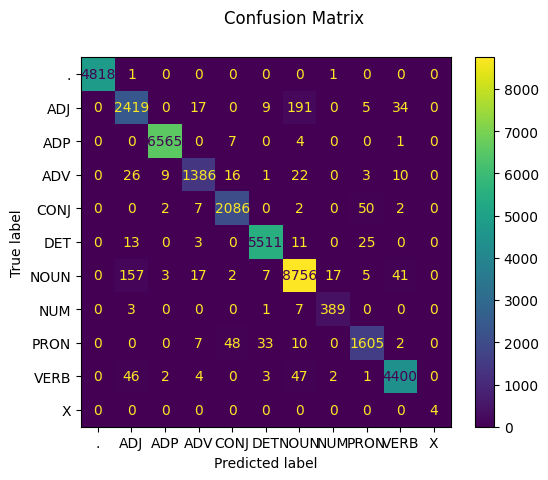

In [116]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test_flat, y_pred_flat)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

#### Precision, recall y F1-score para multiclass


- Macro avg: Calculo de la metrica de cada clase para despues se obtener el average no ponderado
- Weighted avg : Calculo de las metricas de cada clase y obteniendo si average ponderado con la cantidad de instancias de cada clase (*support*)
    - útil para datasets no balanceados

In [117]:
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

           .       1.00      1.00      1.00      4820
         ADJ       0.91      0.90      0.91      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.94      0.95      1473
        CONJ       0.97      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.97      0.97      0.97      9005
         NUM       0.95      0.97      0.96       400
        PRON       0.95      0.94      0.94      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      1.00      1.00         4

    accuracy                           0.98     38876
   macro avg       0.97      0.97      0.97     38876
weighted avg       0.98      0.98      0.98     38876



### Práctica 2: Niveles lingüísticos II
**Fecha de entrega 10 de Marzo de 2024 11:59pm**



- Implementar un etiquetador POS para el idioma otomí
    - Escenario retador de bajos recursos lingüísticos (low-resources)
    - Considerar que las feature functions **deben** cambiar (van acorde a la lengua)
    - Pueden usar bibliotecas conocidas para la implementación
- Reportar accurary, precision, recall y F1-score
- Mostrar un ejemplo de oracion etiquetada (Debe ser una oracion del conjunto de pruebas). Formato libre

#### Extra

- Implementar un HMM para la misma tarea de etiquetado POS para el otomí
- Comparar las siguientes medidas con los resultados obtenidos por el modelo CRF:
  - accuracy
  - precision
  - recall
  - F1-score
- Hacer un análisis breve de los resultados
    - ¿Qué diferencias encuentran entre trabajar con textos en español y en Otomí?
    - ¿Se obtuvieron mejores resultados que con el español?
    - ¿A qué modelo le fue mejor? ¿Porqué? 

### Corpus

- [DESCARGA 📕](https://drive.google.com/file/d/1ihr6gixN7NUkeq9MswJIdXV5Rda-hRFI/view?usp=drive_link)
- Oraciones del Otomí de Toluca, variante de la región San Andrés Cuexcontitlan
- Glosado manual por [Dr. Victor Mijangos de la Cruz](https://sites.google.com/site/victormijangoscruz/?pli=1)

#### Estructura de cada línea

```
[[[CHUNK, GLOSS], [CHUNK, GLOSS],..., POS],...]
  |---------------------------------|
                WORD
```

##### Ejemplo

```python
[
    [['por', 'stem'], 'obl'],
    #   |      |        |
    # CHUNK, GLOSS,    POS
    [['eso', 'stem'], 'obl'],
    [
        ['n', 'psd'],
        ['ga', '3.pls'],
        ['má', 'ctrf'],
        ["'u̱n", 'stem'],
        ['gí', '1.obj'], 'v'] # ngamá'u̱ngí
]
```

#### NOTA

El corpus tiene etiquetas no ascii y esto puede hacer que surgan problemas a la hora de entrenar el modelo. Hay varios enfoques que se pueden tomar para resolver este inconveniente. 

<img src="https://media.discordapp.net/attachments/1140411415254007866/1154645479871746068/image.png?ex=65ea9d66&is=65d82866&hm=21bd1f8a0c42e40b2c44757a6a2b34fd12a4f0b0398a114f404618aa7b27f56f&=&format=webp&quality=lossless">

1. Mapear las etiquetas a su version sin acento:

`méxico -> mexico`

2. Mapear las etiquetas a una categoría (perdida de información lingüística)

  - `méxico -> N`
  - `andrés -> N`

##### Etiquetas y su significado

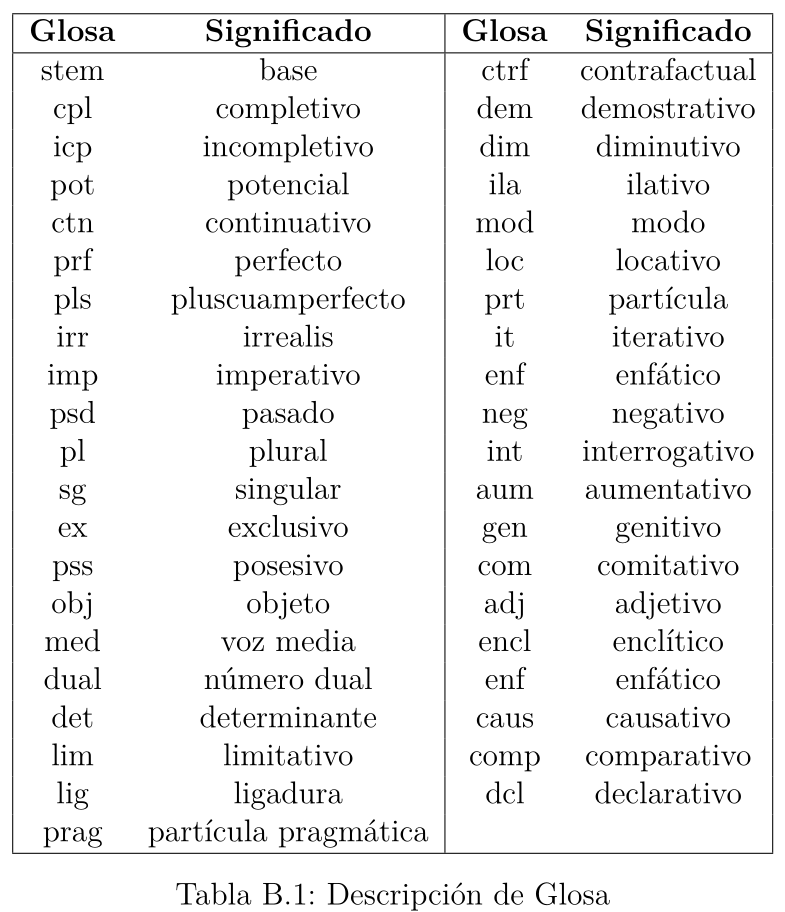

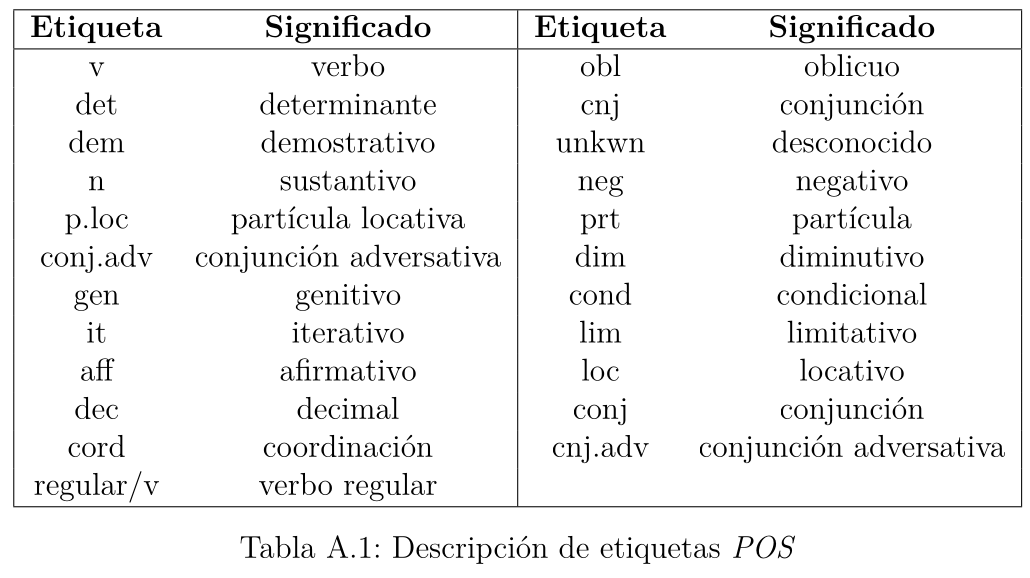

## Referencias

- [POS taggin using CRFs](https://towardsdatascience.com/pos-tagging-using-crfs-ea430c5fb78b)
- [CRFs](https://www.davidsbatista.net/blog/2017/11/13/Conditional_Random_Fields/) ⭐
- [Conditional Random Fields : Data Science Concepts](https://www.youtube.com/watch?v=rI3DQS0P2fk) 📹
- [Multi-label metrics](https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification) 📊